# Perfil del trabajador informal: ENOE vs literatura

## Introducción 

##### La informalidad laboral es un problema estructural caracterizado por la precariedad en las condiciones de trabajo: bajos salarios, largas jornadas, escasa o nula capacitación, y ausencia de prestaciones y seguridad social. Este fenómeno está impulsado tanto por los beneficios de evadir obligaciones fiscales y regulatorias, como por las barreras estructurales para acceder a la formalidad (Rodríguez et al., 2016).

##### El empleo informal perpetúa la pobreza y profundiza la desigualdad, con ello impacta negativamente en la productividad y el crecimiento económico. Según la OIT (2013), en América Latina y el Caribe, este fenómeno afecta con mayor intensidad a grupos vulnerables como jóvenes, mujeres, migrantes y personas en situación de pobreza. Por ejemplo, el 84% de los trabajadores por cuenta propia son informales, así como el 79% del personal doméstico, el 33% de quienes laboran en el sector privado y el 60% de quienes trabajan en microempresas.


## Objetivo

##### Identificar el perfil sociodemográfico y laboral de los trabajadores informales en México.
##### Explicar las variaciones estructurales que relacionan el trabajo informal con la pobreza.



## Metodología

##### Se utilizó la base de datos de la ENOE (3er trimestre de 2024) con enfoque en trabajadores ocupados con encuestas completas y en edad laboral (15 a 65 años). Se filtraron los datos para eliminar registros con ingresos negativos o extremos, y se aplicó el factor de expansión (fac_tri) para ponderar los resultados. La clasificación de empleos formales e informales se basó en la condición de la primera actividad (emp_ppal), con el fin de establecer los dos grupos de interés para su posterior comparación según características sociodemográficas (sexo, edad, escolaridad, ubicación geográfica) y condiciones laborales (jornada laboral, tipo de ocupación).

##### En la segunda parte del análisis, se aplicó la prueba de normalidad de Shapiro-Wilk sobre las variables de ingreso (ingocup) y duración de la jornada laboral (dur9c). Dado que no se observó una distribución normal, se recurrió a la prueba no paramétrica de Kruskal-Wallis para evaluar la relación entre el ingreso y el nivel educativo, así como entre el ingreso y la duración de la jornada, tanto en trabajadores formales como informales. Posteriormente, se empleó la prueba post hoc de Dunn para identificar entre qué grupos se presentan diferencias significativas. Finalmente, se aplicó una prueba chi-cuadrada para explorar la relación entre el sector económico y la condición de formalidad.


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import mode,skew
import pyreadstat 

In [3]:
df = pd.read_stata(r"C:\Users\ASTRID\Downloads\enoe_2024_trim3_dta\ENOE_SDEMT324.dta", convert_categoricals=False)

##### Comienza la limpieza de datos y creación de DataFrames

In [368]:
#quedarme solo con r_def == 00 porque tiene encuestas completas
#restringir por clase2==1 porque son las encuestas de los ocupados
df_informal = df[
    (df['r_def'] == 0) &   # Solo encuestas completas (00 es igual a 0 en int)
    (df['clase2'] == 1) &  # Solo ocupados
    (df['eda'] >= 15) &    # Edad mínima 15 años, primero fue de 18, pero por los datos obtenidos posteriormente, vi necesario bajar la edad mínima
    (df['eda'] <= 65) &    # Edad máxima 65 años
    (df['ingocup'] != 0) & # Ingresos distintos de cero
    (df['emp_ppal'] == 1)   # Solo los que tienen empleo informal
]
filas, columnas = df_informal.shape #las columnas son las variables y las filas las observaciones (viviendas)
print(f'Tamano de la base de datos: {filas} filas y {columnas} columnas')
print('Primeras filas del dataframe:\n ', df_informal.head())

Tamano de la base de datos: 63553 filas y 115 columnas
Primeras filas del dataframe:
      r_def  loc   mun   est  est_d_tri  est_d_men  ageb  t_loc_tri  t_loc_men  \
20    0.0  NaN  11.0  30.0      676.0      637.0   0.0        1.0        1.0   
21    0.0  NaN  12.0  30.0      676.0      637.0   0.0        1.0        1.0   
44    0.0  NaN   2.0  40.0      677.0      638.0   0.0        1.0        1.0   
56    0.0  NaN  17.0  30.0      124.0      115.0   0.0        1.0        1.0   
71    0.0  NaN   2.0  20.0      123.0      116.0   0.0        1.0        1.0   

    cd_a  ...  t_tra  emp_ppal  tue_ppal  trans_ppal  mh_fil2  mh_col  \
20   1.0  ...    1.0       1.0       2.0         0.0      3.0     1.0   
21   1.0  ...    2.0       1.0       1.0         0.0      1.0     7.0   
44   1.0  ...    2.0       1.0       1.0         0.0      1.0     7.0   
56   1.0  ...    1.0       1.0       1.0         0.0      1.0     7.0   
71   1.0  ...    1.0       1.0       1.0         0.0      1.0     7

In [369]:
print(df_informal[['eda', 'ingocup', 'emp_ppal']].describe())  # Resumen estadístico
print(df_informal['r_def'].unique())      # Valores únicos en r_def
print(df_informal['eda'].min(), df['eda'].max())  # Mínimo y máximo de edad

                eda        ingocup  emp_ppal
count  63553.000000   63553.000000   63553.0
mean      38.557613    7532.871525       1.0
std       13.794227    6095.955828       0.0
min       15.000000      14.000000       1.0
25%       27.000000    4000.000000       1.0
50%       38.000000    6450.000000       1.0
75%       50.000000    9030.000000       1.0
max       65.000000  154800.000000       1.0
[0.]
15.0 99.0


In [370]:
df_formal = df[
    (df['r_def'] == 0) &   # Solo encuestas completas (00 es igual a 0 en int)
    (df['clase2'] == 1) &  # Solo ocupados
    (df['eda'] >= 15) &    # Edad mínima 15 años
    (df['eda'] <= 65) &    # Edad máxima 65 años
    (df['ingocup'] != 0) & # Ingresos distintos de cero
    (df['emp_ppal'] == 2)   # Solo los que tienen seguridad social
]
filas, columnas = df_formal.shape #las columnas son las variables y las filas las observaciones (viviendas)
print(f'Tamano de la base de datos: {filas} filas y {columnas} columnas')
print('Primeras filas del dataframe:\n ', df_formal.head())

Tamano de la base de datos: 61223 filas y 115 columnas
Primeras filas del dataframe:
      r_def  loc   mun   est  est_d_tri  est_d_men  ageb  t_loc_tri  t_loc_men  \
1     0.0  NaN  10.0  30.0      124.0        NaN   0.0        1.0        NaN   
25    0.0  NaN  13.0  30.0      676.0      637.0   0.0        1.0        1.0   
34    0.0  NaN  11.0  20.0      123.0        NaN   0.0        1.0        NaN   
35    0.0  NaN  17.0  30.0      676.0      637.0   0.0        1.0        1.0   
36    0.0  NaN  17.0  30.0      676.0      637.0   0.0        1.0        1.0   

    cd_a  ...  t_tra  emp_ppal  tue_ppal  trans_ppal  mh_fil2  mh_col  \
1    1.0  ...    1.0       2.0       2.0         0.0      3.0     2.0   
25   1.0  ...    1.0       2.0       2.0         0.0      3.0     2.0   
34   1.0  ...    1.0       2.0       2.0         0.0      3.0     2.0   
35   1.0  ...    1.0       2.0       2.0         0.0      3.0     2.0   
36   1.0  ...    1.0       2.0       2.0         0.0      3.0     2

In [371]:
print(df_informal.head())

    r_def  loc   mun   est  est_d_tri  est_d_men  ageb  t_loc_tri  t_loc_men  \
20    0.0  NaN  11.0  30.0      676.0      637.0   0.0        1.0        1.0   
21    0.0  NaN  12.0  30.0      676.0      637.0   0.0        1.0        1.0   
44    0.0  NaN   2.0  40.0      677.0      638.0   0.0        1.0        1.0   
56    0.0  NaN  17.0  30.0      124.0      115.0   0.0        1.0        1.0   
71    0.0  NaN   2.0  20.0      123.0      116.0   0.0        1.0        1.0   

    cd_a  ...  t_tra  emp_ppal  tue_ppal  trans_ppal  mh_fil2  mh_col  \
20   1.0  ...    1.0       1.0       2.0         0.0      3.0     1.0   
21   1.0  ...    2.0       1.0       1.0         0.0      1.0     7.0   
44   1.0  ...    2.0       1.0       1.0         0.0      1.0     7.0   
56   1.0  ...    1.0       1.0       1.0         0.0      1.0     7.0   
71   1.0  ...    1.0       1.0       1.0         0.0      1.0     7.0   

    sec_ins  tipo  mes_cal    nivel_educ  
20      7.0   1.0      8.0      Super

In [372]:
print(len(df_formal)) #solo para asegurar que no son df vacíos
print(len(df_informal))

61223
63553


In [377]:
df_informal['ingocup'].describe() #datos no ponderados

count     63553.000000
mean       7532.871525
std        6095.955828
min          14.000000
25%        4000.000000
50%        6450.000000
75%        9030.000000
max      154800.000000
Name: ingocup, dtype: float64

In [376]:
df_formal['ingocup'].describe()

count     61223.000000
mean      13184.009866
std        9285.064647
min         100.000000
25%        8000.000000
50%       10750.000000
75%       15050.000000
max      220000.000000
Name: ingocup, dtype: float64

In [378]:
#funcion para eliminar outliers (datos extremos) usando el rango intercuartil (IQR)
def eliminar_outliers(df_informal, columna):
    Q1 = df_informal[columna].quantile(0.25)
    Q3 = df_informal[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inf = Q1 - 1.5 * IQR
    limite_sup = Q3 + 1.5 * IQR #normalmebte no es 1.5, sino a partir de 3
    return df_informal[(df_informal[columna] >= limite_inf)&(df_informal[columna]<= limite_sup)]
df_informal= eliminar_outliers(df_informal, 'ingocup') #salario

In [379]:
#funcion para eliminar outliers (datos extremos) usando el rango intercuartil (IQR)
def eliminar_outliers(df_formal, columna):
    Q1 = df_formal[columna].quantile(0.25)
    Q3 = df_formal[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inf = Q1 - 1.5 * IQR
    limite_sup = Q3 + 1.5 * IQR #normalmebte no es 1.5, sino a partir de 3
    return df_formal[(df_formal[columna] >= limite_inf)&(df_formal[columna]<= limite_sup)]
df_formal= eliminar_outliers(df_formal, 'ingocup') #salario

## Análisis de la edad

In [380]:
edad_media = (df_informal['eda'] * df_informal['fac_tri']).sum() / df_informal['fac_tri'].sum()
print(f"Edad promedio ponderada: {edad_media:.2f}")

moda_ponderada = (
    df_informal.groupby('eda')['fac_tri'].sum()
    .sort_values(ascending=False)
    .idxmax()
)
print(f"Edad moda ponderada: {moda_ponderada}")

Edad promedio ponderada: 38.56
Edad moda ponderada: 18.0


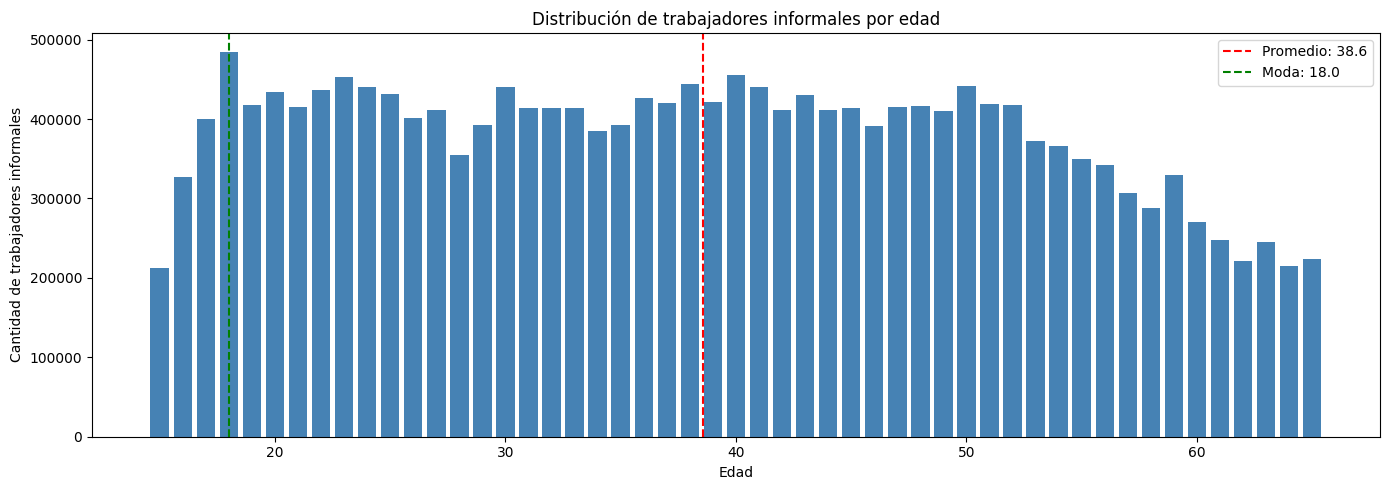

In [418]:
edad_pond = df_informal.groupby('eda')['fac_tri'].sum() #este no es el cálculo ponderado real, solo mide distribución


plt.figure(figsize=(14, 5))
plt.bar(edad_pond.index, edad_pond.values, color='steelblue')
plt.axvline(edad_media, color='red', linestyle='--', label=f'Promedio: {edad_media:.1f}')
plt.axvline(moda_ponderada, color='green', linestyle='--', label=f'Moda: {moda_ponderada}')
plt.xlabel('Edad')
plt.ylabel('Cantidad de trabajadores informales')
plt.title('Distribución de trabajadores informales por edad')
plt.legend()
plt.tight_layout()
plt.savefig("trabajadores_por_edad.png", dpi=300)  # para guardar en diferentes formatos
plt.show()

In [390]:
def determinar_anios_edu(valor): 
    if valor in range (15, 20):
        return '15 a 19'
    elif valor in range (20, 25): 
        return '20 a 24'  
    elif valor in range (25, 30):  
        return '25 a 29'
    elif valor in range (30, 35):
        return '30 a 34'
    elif valor in range (35, 40):
        return '35 a 39'
    elif valor in range (40, 45):
        return '40 a 44'
    elif valor in range (45, 50): 
        return '45 a 49'  
    elif valor in range (50, 55):  
        return '50 a 54'
    elif valor in range (55, 60):
        return '55 a 59'
    elif valor in range (60, 65):
        return '60 a 64'
    else:
        return None  # Ignorar otros valores

# Crear una copia
df_anios = df_informal.copy()

# Aplica la clasificacion solo en la copia
df_anios['edad_educacion'] = df_anios['eda'].apply(determinar_anios_edu)


# Ponderar
frec_anios_edu = df_anios.groupby('edad_educacion')['fac_tri'].sum().reset_index()
frec_anios_edu.columns = ['Edad', 'Frecuencia ponderada']
#Porcentaje
total_anios_edu = frec_anios_edu['Frecuencia ponderada'].sum()
frec_anios_edu['Porcentaje de trabajadores informales (%)'] = (frec_anios_edu['Frecuencia ponderada'] / total_anios_edu * 100).round(2)

# tabla
from tabulate import tabulate
print(tabulate(frec_anios_edu, headers='keys', tablefmt='github'))

|    | Edad    |   Frecuencia ponderada |   Porcentaje de trabajadores informales (%) |
|----|---------|------------------------|---------------------------------------------|
|  0 | 15 a 19 |            1.84138e+06 |                                        9.59 |
|  1 | 20 a 24 |            2.17848e+06 |                                       11.34 |
|  2 | 25 a 29 |            1.99028e+06 |                                       10.36 |
|  3 | 30 a 34 |            2.06795e+06 |                                       10.76 |
|  4 | 35 a 39 |            2.10481e+06 |                                       10.96 |
|  5 | 40 a 44 |            2.14947e+06 |                                       11.19 |
|  6 | 45 a 49 |            2.04691e+06 |                                       10.66 |
|  7 | 50 a 54 |            2.0166e+06  |                                       10.5  |
|  8 | 55 a 59 |            1.61603e+06 |                                        8.41 |
|  9 | 60 a 64 |            1.19

##### Aunque los factores intentan compensar (fac_tri * eda), la concentración real de trabajadores jóvenes en la informalidad es muy alta en México, por lo que hay una gran diferencia entre la media ponderada y la moda ponderada

## Análisis del sexo

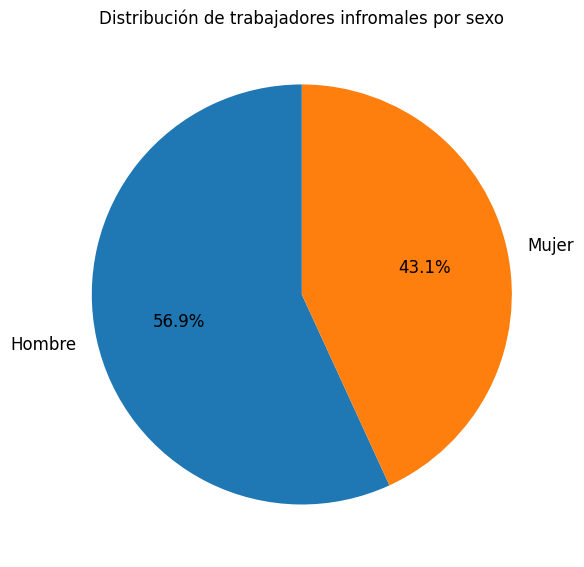

In [419]:
sexo_ponderado = (df_informal['sex'] * df_informal['fac_tri']).sum() / df_informal['fac_tri'].sum()
# Crear una columna con el sexo como texto
df_informal['sexo_str'] = df_informal['sex'].map({1: 'Hombre', 2: 'Mujer'})

# Agrupar por sexo y aplicar el factor de expansión
sexo_ponderado = df_informal.groupby('sexo_str')['fac_tri'].sum()

fig, ax = plt.subplots(figsize=(6, 6))
sexo_ponderado.plot(kind='pie', autopct='%1.1f%%', title='Distribución de trabajadores infromales por sexo', startangle=90, ax=ax, textprops={'fontsize': 12})
ax.set_ylabel('')  # Elimina etiqueta innecesaria del eje Y
plt.tight_layout()
plt.savefig("trabajadores_por_sexo.png", dpi=300)
plt.show()

##### Se confirma visualmente la prevalencia de hombres como trabajadores informales

## Analisis por nivel educativo

In [394]:
"""
esta función permitirá clasificar los niveles educativos entre las categorías del análisis: 
1. Educación básica (preescolar, primaria y secundaria)
2. Educación superior (preparatoria, normal, escuela técnica, universidad)
3. Educación de especialidad (maestría y doctorado)
"""
def clasificar_educacion(valor):
    if valor == 0:
        return 'Sin estudios'
    elif valor in [1, 2, 3]:
        return 'Básica'
    elif valor in [4, 5, 6, 7]:
        return 'Superior'
    elif valor in [8,9]:
        return'Especialidad'
    else:
        return 'No especificado'

df_informal.loc[:,'nivel_educativo'] = df_informal['cs_p13_1'].apply(clasificar_educacion).copy()
df_anios.loc[:, 'nivel_educativo'] = df_anios['cs_p13_1'].apply(clasificar_educacion).copy() #surge un error más adelante, aquí intento evitarlo

In [385]:
import pandas as pd
!pip install  tabulate
from tabulate import tabulate  # Opcional, pero se va más bonito y estilizado 
#datos no ponderados
frecuencia_educacion = df_informal['nivel_educativo'].value_counts().reset_index()
frecuencia_educacion.columns = ['Nivel educativo', 'Frecuencia absoluta']
frecuencia_educacion['Frecuencia relativa (%)'] = (frecuencia_educacion['Frecuencia absoluta'] / frecuencia_educacion['Frecuencia absoluta'].sum()) * 100
frecuencia_educacion['Frecuencia relativa (%)'] = frecuencia_educacion['Frecuencia relativa (%)'].round(4)

# Mostrar tabla en consola con formato 
print(tabulate(frecuencia_educacion, headers='keys', tablefmt='github'))


|    | Nivel educativo   |   Frecuencia absoluta |   Frecuencia relativa (%) |
|----|-------------------|-----------------------|---------------------------|
|  0 | Básica            |                 34973 |                   58.265  |
|  1 | Superior          |                 22831 |                   38.0365 |
|  2 | Sin estudios      |                  1922 |                    3.2021 |
|  3 | Especialidad      |                   258 |                    0.4298 |
|  4 | No especificado   |                    40 |                    0.0666 |



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [420]:
# Agrupar por nivel educativo y aplicar ponderación
frecuencia_educacion_pond = df_informal.groupby('nivel_educativo')['fac_tri'].sum().reset_index()

# Renombrar columnas
frecuencia_educacion_pond.columns = ['Nivel educativo', 'Frecuencia ponderada']

# Calcular frecuencia relativa en porcentaje
total = frecuencia_educacion_pond['Frecuencia ponderada'].sum()
frecuencia_educacion_pond['Frecuencia relativa (%)'] = (frecuencia_educacion_pond['Frecuencia ponderada'] / total) * 100
frecuencia_educacion_pond['Frecuencia relativa (%)'] = frecuencia_educacion_pond['Frecuencia relativa (%)'].round(4)

# Mostrar tabla en formato 
print(tabulate(frecuencia_educacion_pond, headers='keys', tablefmt='github'))

|    | Nivel educativo   |   Frecuencia ponderada |   Frecuencia relativa (%) |
|----|-------------------|------------------------|---------------------------|
|  0 | Básica            |            1.19155e+07 |                   61.311  |
|  1 | Especialidad      |        68731           |                    0.3537 |
|  2 | No especificado   |        13195           |                    0.0679 |
|  3 | Sin estudios      |       780302           |                    4.015  |
|  4 | Superior          |            6.65678e+06 |                   34.2524 |


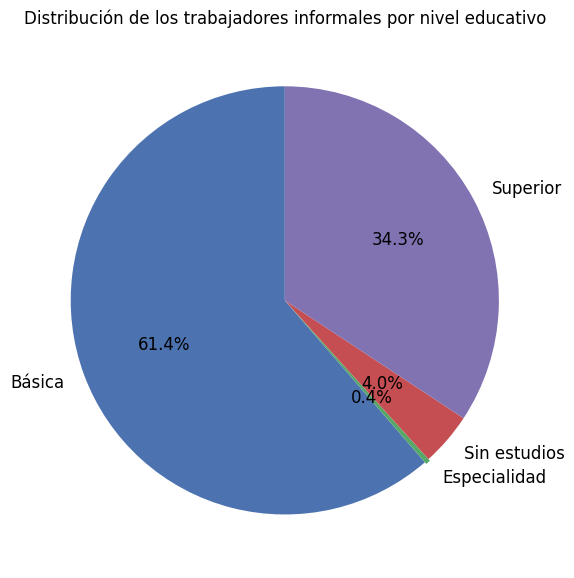

In [421]:
''' Filtrar solo categorías relevantes
Aquí elimino abiertamente la categoría no especificado porque el porcentaje de observaciones es mínimo
'''
data = frecuencia_educacion_pond[frecuencia_educacion_pond['Nivel educativo'] != 'No especificado']


colores = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974', '#64B5CD']
labels = data['Nivel educativo']
sizes = data['Frecuencia ponderada'].values
explode = [0.01 if label == 'Especialidad' else 0 for label in labels]


fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colores,
    explode=explode,
    textprops={'fontsize': 12}
)

ax.set_title('Distribución de los trabajadores informales por nivel educativo')
ax.set_ylabel('')  
plt.tight_layout()
plt.savefig("trabajadores_por_educacion.png", dpi=300)
plt.show()


##### Nuevamente, se viasualiza la prevalencia de la educación básica entre los trabajadores informales

In [387]:
# Función para clasificar los niveles básicos
def determinar_basica(valor): 
    if valor == 1:
        return 'Preescolar'
    elif valor == 2: 
        return 'Primaria' 
    elif valor == 3:  
        return 'Secundaria'
    else:
        return None  # Ignorar otros valores

# Clasificar primaria y secundaria en df_informal
df_informal['nivel_basico'] = df_informal['cs_p13_1'].apply(determinar_basica)

#Filtrar solo los que están en primaria o secundaria
df_basica = df_informal[df_informal['nivel_basico'].notna()]
# Ponderar
frec_edu_basica = df_basica.groupby('nivel_basico')['fac_tri'].sum().reset_index()
frec_edu_basica.columns = ['Nivel', 'Frecuencia ponderada']
#Porcentaje
total_edu_basica = frec_edu_basica['Frecuencia ponderada'].sum()
frec_edu_basica['Porcentaje dentro de básica (%)'] = (
    frec_edu_basica['Frecuencia ponderada'] / total_edu_basica * 100
).round(2)

# tabla
from tabulate import tabulate
print(tabulate(frec_edu_basica, headers='keys', tablefmt='github'))


|    | Nivel      |   Frecuencia ponderada |   Porcentaje dentro de básica (%) |
|----|------------|------------------------|-----------------------------------|
|  0 | Preescolar |         7697           |                              0.06 |
|  1 | Primaria   |            5.04791e+06 |                             42.36 |
|  2 | Secundaria |            6.85986e+06 |                             57.57 |


In [388]:
# Exactamente lo mismo de arriba, ahora para la educación superior (quiero revisar porcentajes de educación de preparatoria)
def determinar_media(valor): 
    if valor == 4:
        return 'Preparatoria'
    elif valor == 5: 
        return 'Normal' 
    elif valor == 6:  
        return 'Carrera técnica'
    elif valor == 7:
        return 'Profesional'
    else:
        return None  # Ignorar otros valores

# Clasificar educación media superior en df_informal
df_informal['nivel_medio_superior'] = df_informal['cs_p13_1'].apply(determinar_media)

#Filtrar solo los que están en primaria o secundaria
df_media_sup = df_informal[df_informal['nivel_medio_superior'].notna()]
# Ponderar
frec_edu_media_sup = df_media_sup.groupby('nivel_medio_superior')['fac_tri'].sum().reset_index()
frec_edu_media_sup.columns = ['Nivel', 'Frecuencia ponderada']
#Porcentaje
total_edu_media_sup = frec_edu_media_sup['Frecuencia ponderada'].sum()
frec_edu_media_sup['Porcentaje dentro de media/superior (%)'] = (
    frec_edu_media_sup['Frecuencia ponderada'] / total_edu_media_sup * 100
).round(2)

# tabla
from tabulate import tabulate
print(tabulate(frec_edu_media_sup, headers='keys', tablefmt='github'))

|    | Nivel           |   Frecuencia ponderada |   Porcentaje dentro de media/superior (%) |
|----|-----------------|------------------------|-------------------------------------------|
|  0 | Carrera técnica |       438389           |                                      6.59 |
|  1 | Normal          |         9703           |                                      0.15 |
|  2 | Preparatoria    |            4.31238e+06 |                                     64.78 |
|  3 | Profesional     |            1.89631e+06 |                                     28.49 |


##### Dentro del porcentaje de trabajadores informales que tienen educación básica, se observa que la mayoría tiene estudios hasta la secundaria. Mientras que entre los trabajadores informales con educación superior, la gran mayoría queda rezagado en la preparatoria, sin acceso a educación superior

In [392]:
print(df_informal['eda'].unique())

[49. 65. 43. 51. 58. 57. 62. 15. 44. 31. 54. 48. 22. 39. 47. 20. 38. 26.
 40. 56. 17. 36. 30. 24. 32. 28. 63. 21. 18. 25. 42. 45. 46. 27. 60. 37.
 34. 52. 53. 16. 59. 23. 29. 19. 55. 50. 33. 41. 61. 64. 35.]


In [395]:
'''
Aquí estoy cruzando información de edades de interés con los niveles educativos. Principalmente tomé los grupos por los datos de la moda (18 años) y la media (39 años) que ya 
estaban ponderados. Además de los adultos mayores, ya que su prevalencia (y la gran cantidad de jóvenes) son -teóricamente- la razón de la diferencia tan grande entre moda y media
'''

grupos_interes = ['15 a 19', '20 a 24', '35 a 39', '60 a 64']  

tabla_cruzada = df_anios.groupby(['edad_educacion', 'nivel_educativo'])['fac_tri'].sum().reset_index()

tabla_clave = tabla_cruzada[tabla_cruzada['edad_educacion'].isin(grupos_interes)].copy()

# Para convertir a porcentajes por grupo de edad
tabla_clave['% En el grupo de edad'] = tabla_clave.groupby('edad_educacion')['fac_tri'].transform(lambda x: (x / x.sum()) * 100).round(2)

tabla_clave.columns = ['Edad', 'Nivel educativo', 'Frecuencia ponderada', '% En el grupo de edad']

print(tabulate(tabla_clave, headers='keys', tablefmt='github'))

|    | Edad    | Nivel educativo   |   Frecuencia ponderada |   % En el grupo de edad |
|----|---------|-------------------|------------------------|-------------------------|
|  0 | 15 a 19 | Básica            |            1.08808e+06 |                   59.09 |
|  1 | 15 a 19 | No especificado   |          209           |                    0.01 |
|  2 | 15 a 19 | Sin estudios      |        16265           |                    0.88 |
|  3 | 15 a 19 | Superior          |       736830           |                   40.02 |
|  4 | 20 a 24 | Básica            |       858796           |                   39.42 |
|  5 | 20 a 24 | Especialidad      |         2667           |                    0.12 |
|  6 | 20 a 24 | No especificado   |           34           |                    0    |
|  7 | 20 a 24 | Sin estudios      |        21847           |                    1    |
|  8 | 20 a 24 | Superior          |            1.29514e+06 |                   59.45 |
| 19 | 35 a 39 | Básica         

## Tipo de unidad económica

In [396]:
#función para catalogar el tamaño de las unidades económicas
def clasificar_ambito(valor):
    if valor in [2, 3]:
        return 'Micronegocio (sin/con establecimiento)'
    elif valor == 4:
        return 'Pequeño'
    elif valor in [5, 6]:
        return 'Mediano/Grande'
    elif valor == 7:
        return 'Gobierno'
    else:
        return 'Otro'

df_informal.loc[:,'tam_unidad'] = df_informal['ambito2'].apply(clasificar_ambito).copy()


In [397]:
#datos no ponderados tabulados
tam_uni_frec = df_informal['tam_unidad'].value_counts().reset_index()
tam_uni_frec.columns = ['Tamaño de Unidad Económica', 'Frecuencia absoluta']
tam_uni_frec['Frecuencia relativa (%)'] = (tam_uni_frec['Frecuencia absoluta'] / tam_uni_frec['Frecuencia absoluta'].sum()) * 100
tam_uni_frec['Frecuencia relativa (%)'] = tam_uni_frec['Frecuencia relativa (%)'].round(4)

# Mostrar tabla en consola con formato 
print(tabulate(tam_uni_frec, headers='keys', tablefmt='github'))


|    | Tamaño de Unidad Económica             |   Frecuencia absoluta |   Frecuencia relativa (%) |
|----|----------------------------------------|-----------------------|---------------------------|
|  0 | Micronegocio (sin/con establecimiento) |                 37971 |                   63.2597 |
|  1 | Otro                                   |                 14527 |                   24.202  |
|  2 | Pequeño                                |                  5598 |                    9.3263 |
|  3 | Mediano/Grande                         |                  1132 |                    1.8859 |
|  4 | Gobierno                               |                   796 |                    1.3261 |


In [422]:
# Agrupar por nivel educativo y aplicar el factor de expansion
frec_ponderada = df_informal.groupby('tam_unidad')['fac_tri'].sum().reset_index()

# Renombrar columnas
frec_ponderada.columns = ['Tamaño de unidad', 'Frecuencia ponderada']

# Calcular frecuencia relativa (%)
frec_ponderada['Frecuencia relativa (%)'] = (frec_ponderada['Frecuencia ponderada'] / total) * 100
frec_ponderada['Frecuencia relativa (%)'] = frec_ponderada['Frecuencia relativa (%)'].round(4)

# Mostrar tabla en formato 
print(tabulate(frec_ponderada, headers='keys', tablefmt='github'))

|    | Tamaño de unidad                       |   Frecuencia ponderada |   Frecuencia relativa (%) |
|----|----------------------------------------|------------------------|---------------------------|
|  0 | Gobierno                               |       228064           |                    1.1735 |
|  1 | Mediano/Grande                         |       315297           |                    1.6224 |
|  2 | Micronegocio (sin/con establecimiento) |            1.19738e+07 |                   61.6111 |
|  3 | Otro                                   |            5.35032e+06 |                   27.53   |
|  4 | Pequeño                                |            1.56701e+06 |                    8.063  |


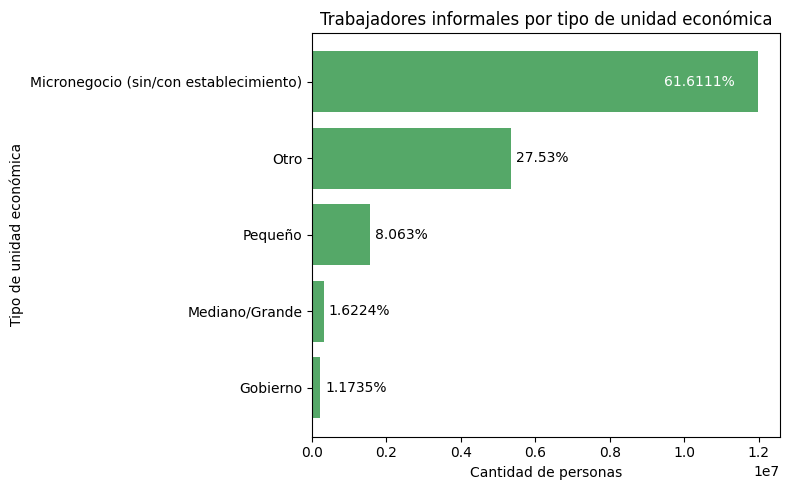

In [406]:
frec_ponderada = frec_ponderada.sort_values('Frecuencia relativa (%)')

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(
    frec_ponderada['Tamaño de unidad'],
    frec_ponderada['Frecuencia ponderada'],
    color='#55A868'
)

# Obtener el límite del eje x para calcular una posición segura del texto
xlim = ax.get_xlim()[1]

for bar, porcentaje in zip(bars, frec_ponderada['Frecuencia relativa (%)']):
    x = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2

    if x > xlim * 0.85:
        ax.text(x - (xlim * 0.05), y, f'{porcentaje}%', va='center', ha='right', fontsize=10, color='white') # esto lo puse aqui porque el porcentaje se salía del margen aunque agrande el fondo
    else:
        ax.text(x + (xlim * 0.01), y, f'{porcentaje}%', va='center', ha='left', fontsize=10)

ax.set_title('Trabajadores informales por tipo de unidad económica')
ax.set_xlabel('Cantidad de personas')
ax.set_ylabel('Tipo de unidad económica')
plt.tight_layout()
plt.savefig("trabajadores_por_tamaño.png", dpi=300)
plt.show()

##### Podemos observar que hay una gran concentración de trabajadores informales en micronegocios

## Tipo de ocupación

In [423]:
#función para catalogar el tipo de ocupación
def clasificar_ocupacion(valor):
    if valor == 1:
        return 'Trabajadores subordinados y remunerados'
    elif valor == 2:
        return 'Empleadores'
    elif valor == 3:
        return 'Trabajadores por cuenta propia'
    elif valor == 4:
        return 'Trabajadores sin pago'
    elif valor == 5:
        return 'No especificado'
    else:
        return None

df_informal.loc[:,'tipo_ocup'] = df_informal['pos_ocu'].apply(clasificar_ocupacion).copy()

In [424]:
# ailtrar datos sin "No especificado"
df_unidad = df_informal[df_informal['tipo_ocup'] != 'No especificado']

# agrupar por tipo de ocupación y sumar factores de expansión
tip_ocup_frec = df_unidad.groupby('tipo_ocup')['fac_tri'].sum().reset_index()

tip_ocup_frec.columns = ['Tipo de ocupación', 'Frecuencia ponderada']

total = tip_ocup_frec['Frecuencia ponderada'].sum()
tip_ocup_frec['Frecuencia relativa (%)'] = (tip_ocup_frec['Frecuencia ponderada'] / total) * 100
tip_ocup_frec['Frecuencia relativa (%)'] = tip_ocup_frec['Frecuencia relativa (%)'].round(4)

from tabulate import tabulate
print(tabulate(tip_ocup_frec, headers='keys', tablefmt='github'))


|    | Tipo de ocupación                       |   Frecuencia ponderada |   Frecuencia relativa (%) |
|----|-----------------------------------------|------------------------|---------------------------|
|  0 | Empleadores                             |       757625           |                    3.8984 |
|  1 | Trabajadores por cuenta propia          |            6.00521e+06 |                   30.8998 |
|  2 | Trabajadores subordinados y remunerados |            1.26716e+07 |                   65.2019 |


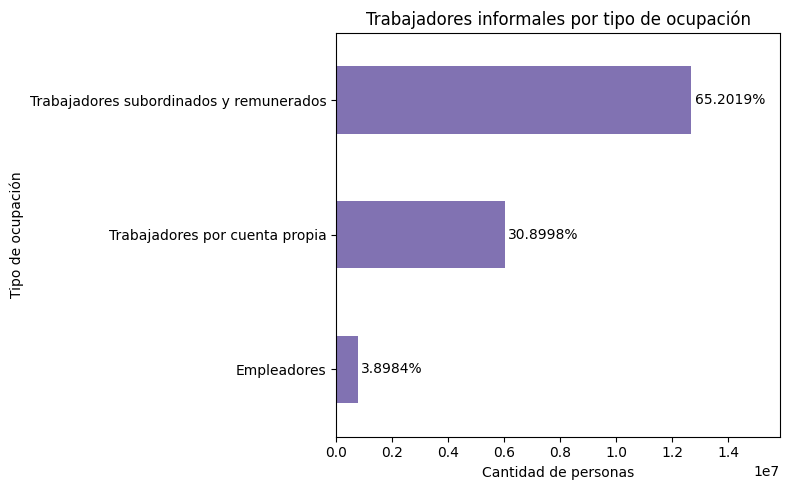

In [425]:
tip_ocup_frec = tip_ocup_frec.sort_values('Frecuencia relativa (%)')


ax = tip_ocup_frec.plot(
    kind='barh',
    x='Tipo de ocupación',
    y='Frecuencia ponderada',
    color='#8172B2',
    figsize=(8,5),
    legend=False
)

# Ajustar límite del eje X para dejar espacio para los porcentajes
max_val = tip_ocup_frec['Frecuencia ponderada'].max()
ax.set_xlim(0, max_val * 1.25) #aqui lo agrando más
#aqui se colocn los % al final de cada barra
for i, (freq, pct) in enumerate(zip(tip_ocup_frec['Frecuencia ponderada'], tip_ocup_frec['Frecuencia relativa (%)'])):
    ax.text(freq + max_val * 0.01, i, f'{pct}%', va='center', fontsize=10)

plt.title('Trabajadores informales por tipo de ocupación')
plt.xlabel('Cantidad de personas')
plt.ylabel('Tipo de ocupación')
plt.tight_layout()
plt.savefig('trabajadores_inf_ocupacion.png', dpi = 300)
plt.show()

##### Observamos que la mayor parte de los trabajadores informales son trabajadores subordinados

## Ubicación geográfica

In [193]:
df_informal['ent'].value_counts().sort_index() #comparación de informalidad por estado

ent
1.0     1051
2.0     1157
3.0      925
4.0     2808
5.0     1662
6.0     1409
7.0     3621
8.0     1209
9.0     1098
10.0    1928
11.0    2031
12.0    1969
13.0    1849
14.0    1530
15.0    2183
16.0    2059
17.0    1182
18.0    2238
19.0    1382
20.0    2215
21.0    2492
22.0     958
23.0    1240
24.0    1405
25.0    1276
26.0    1129
27.0    2003
28.0    1854
29.0    2392
30.0    2950
31.0    2319
32.0    1474
Name: count, dtype: int64

In [194]:
informales_ponderados_estado = df_informal.groupby('ent')['fac_tri'].sum().sort_index()
print(informales_ponderados_estado)

ent
1.0      118154.0
2.0      288828.0
3.0       96839.0
4.0      186424.0
5.0      351821.0
6.0      103767.0
7.0     1197514.0
8.0      346979.0
9.0      995746.0
10.0     290240.0
11.0     793337.0
12.0     596425.0
13.0     616916.0
14.0    1096147.0
15.0    2172690.0
16.0     982807.0
17.0     232467.0
18.0     253188.0
19.0     604864.0
20.0     721310.0
21.0    1238169.0
22.0     210166.0
23.0     258915.0
24.0     365773.0
25.0     427116.0
26.0     339975.0
27.0     476401.0
28.0     475633.0
29.0     285680.0
30.0    1623151.0
31.0     495943.0
32.0     233486.0
Name: fac_tri, dtype: float64


In [26]:
df_formal['ent'].value_counts().sort_index() #comparacion de formalidad por estado

ent
1.0     1487
2.0     2693
3.0     2202
4.0     2881
5.0     3910
6.0     1677
7.0     2432
8.0     3419
9.0     1084
10.0    2618
11.0    2073
12.0     828
13.0    1231
14.0    1954
15.0    1441
16.0    1523
17.0     431
18.0    2307
19.0    2983
20.0     967
21.0    1350
22.0     939
23.0    1831
24.0    1538
25.0    1838
26.0    2205
27.0    1504
28.0    3119
29.0    1143
30.0    1964
31.0    1866
32.0    1617
Name: count, dtype: int64

In [138]:
formales_ponderados_estado = df_formal.groupby('ent')['fac_tri'].sum().sort_index()
print(formales_ponderados_estado)

ent
1.0      176987.0
2.0      602718.0
3.0      206960.0
4.0      133548.0
5.0      760724.0
6.0      110816.0
7.0      428084.0
8.0      743648.0
9.0      930117.0
10.0     331445.0
11.0     721542.0
12.0     188718.0
13.0     271829.0
14.0    1138645.0
15.0    1248644.0
16.0     481938.0
17.0      71830.0
18.0     198138.0
19.0    1193879.0
20.0     195254.0
21.0     511930.0
22.0     195970.0
23.0     359807.0
24.0     310630.0
25.0     496937.0
26.0     569420.0
27.0     237360.0
28.0     681654.0
29.0     131288.0
30.0     648000.0
31.0     348015.0
32.0     164569.0
Name: fac_tri, dtype: float64


##### Explicación rápida: como mi primer análisis de este tipo, estos pequeños df sin formato son sólo una guía para el estudio. Permite identificar rápidamente si hay variaciones extrañas (como la diferencia entre moda y media ponderada) para determinar si son necesarias otras pruebas de confirmación

In [333]:
entidades = {
    1: "Aguascalientes", 2: "Baja California", 3: "Baja California Sur", 4: "Campeche",
    5: "Coahuila", 6: "Colima", 7: "Chiapas", 8: "Chihuahua", 9: "CDMX",
    10: "Durango", 11: "Guanajuato", 12: "Guerrero", 13: "Hidalgo", 14: "Jalisco",
    15: "México", 16: "Michoacán", 17: "Morelos", 18: "Nayarit", 19: "Nuevo León",
    20: "Oaxaca", 21: "Puebla", 22: "Querétaro", 23: "Quintana Roo", 24: "San Luis Potosí",
    25: "Sinaloa", 26: "Sonora", 27: "Tabasco", 28: "Tamaulipas", 29: "Tlaxcala",
    30: "Veracruz", 31: "Yucatán", 32: "Zacatecas"
}

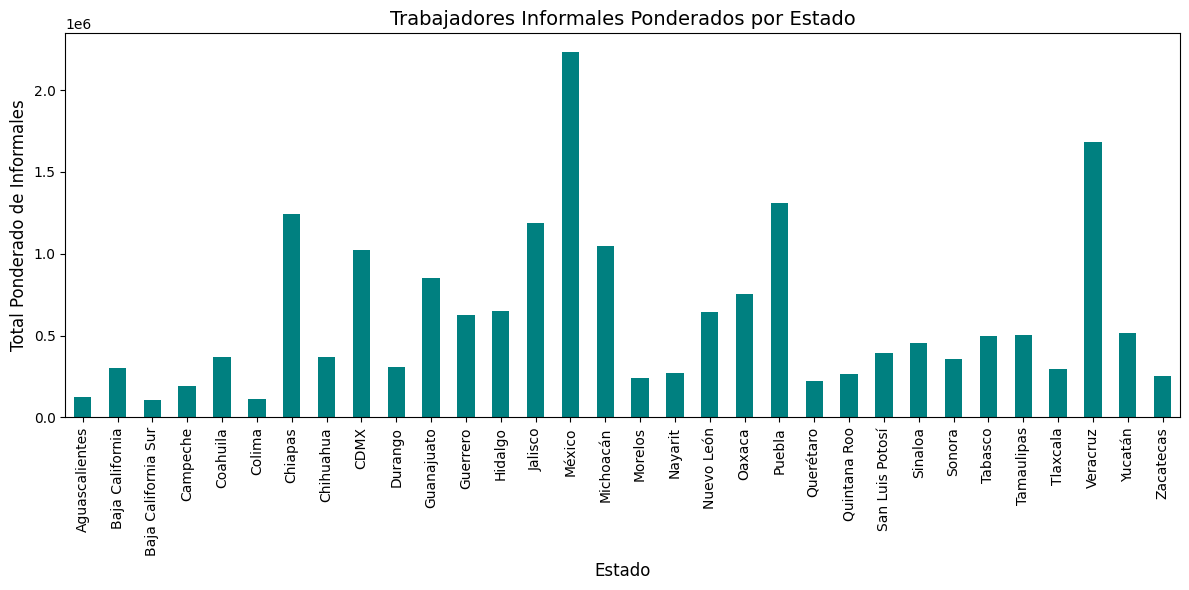

In [426]:
informales_ponderados_estado = df_informal.groupby('ent')['fac_tri'].sum().sort_index()
informales_ponderados_estado.index = informales_ponderados_estado.index.astype(int)

informales_ponderados_estado.index = informales_ponderados_estado.index.map(entidades)

plt.figure(figsize=(12,6))
informales_ponderados_estado.plot(kind='bar', color='teal')
plt.title('Trabajadores Informales Ponderados por Estado', fontsize=14)
plt.xlabel('Estado', fontsize=12)
plt.ylabel('Total Ponderado de Informales', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('trabajadores_informales_estado.png', dpi=300)
plt.show()

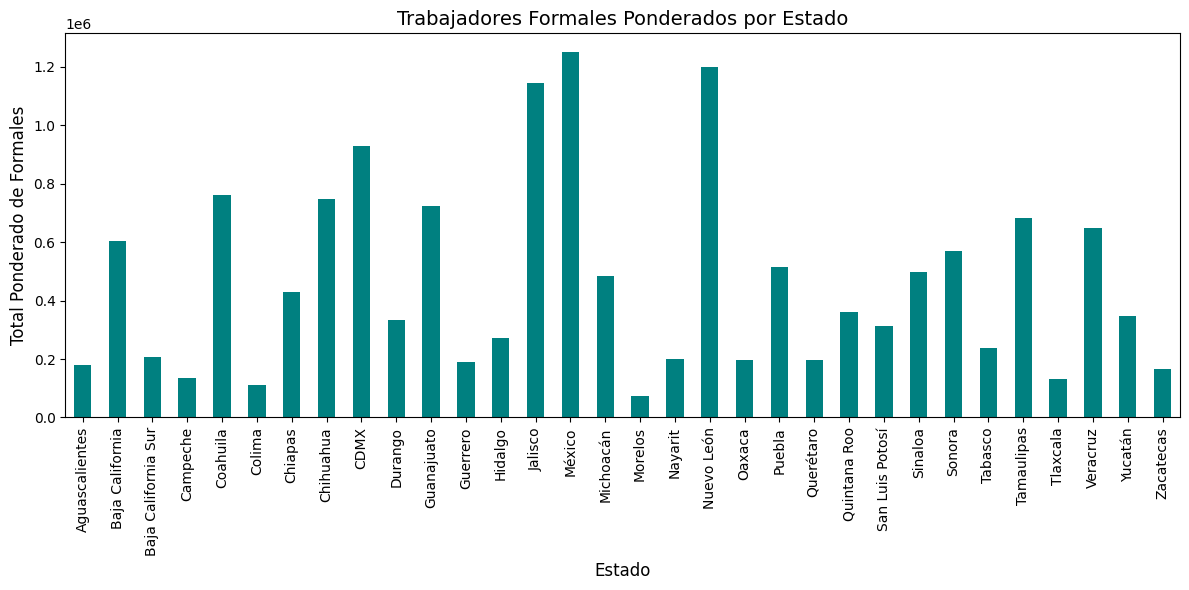

In [409]:
formales_ponderados_estado = df_formal.groupby('ent')['fac_tri'].sum().sort_index()
formales_ponderados_estado.index = formales_ponderados_estado.index.astype(int)

formales_ponderados_estado.index = formales_ponderados_estado.index.map(entidades)

# Ya puedes graficar
plt.figure(figsize=(12,6))
formales_ponderados_estado.plot(kind='bar', color='teal')
plt.title('Trabajadores Formales Ponderados por Estado', fontsize=14)
plt.xlabel('Estado', fontsize=12)
plt.ylabel('Total Ponderado de Formales', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('trabajadores_formales_estado.png', dpi=300)
plt.show()



In [195]:
print(df_informal['ur'].map({1: 'Urbano', 2: 'Rural'}).value_counts(normalize=True) * 100)

ur
Urbano    53.298361
Rural     46.701639
Name: proportion, dtype: float64


In [177]:
print(df_formal['ur'].map({1: 'Urbano', 2: 'Rural'}).value_counts(normalize=True) * 100)

ur
Urbano    72.274401
Rural     27.725599
Name: proportion, dtype: float64


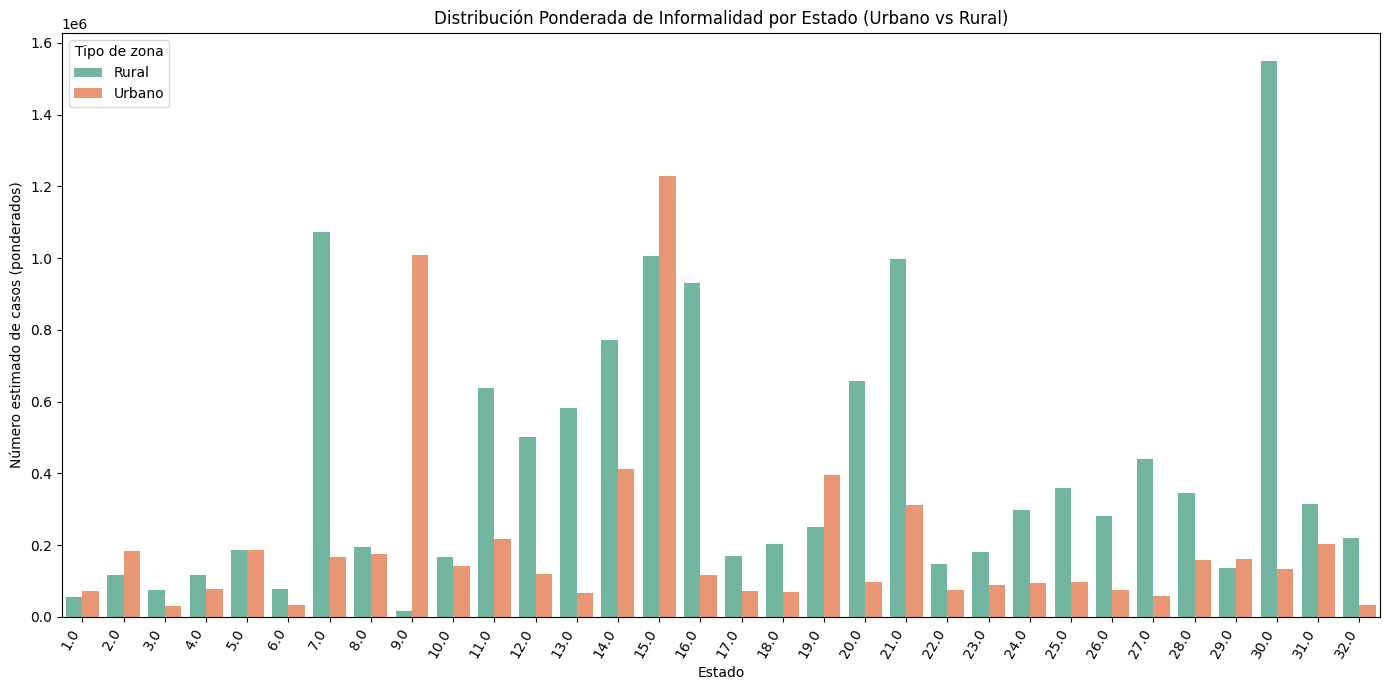

In [427]:
df_informal['zona'] = df_informal['ur'].map({1: 'Urbano', 2: 'Rural'}).astype('category')

# agrupar por entidad y zona
inf_zona = df_informal.groupby(['ent', 'zona'], observed=True)['fac_tri'].sum().reset_index()

plt.figure(figsize=(14, 7))
sns.barplot(data=inf_zona, x='ent', y='fac_tri', hue='zona', palette='Set2')
plt.title('Distribución Ponderada de Informalidad por Estado (Urbano vs Rural)')
plt.xlabel('Estado')
plt.ylabel('Número estimado de casos (ponderados)')
plt.xticks(rotation=60, ha='right')
plt.legend(title='Tipo de zona')
plt.tight_layout()
plt.savefig('dist_pond_inf_estado.png', dpi = 300)
plt.show()


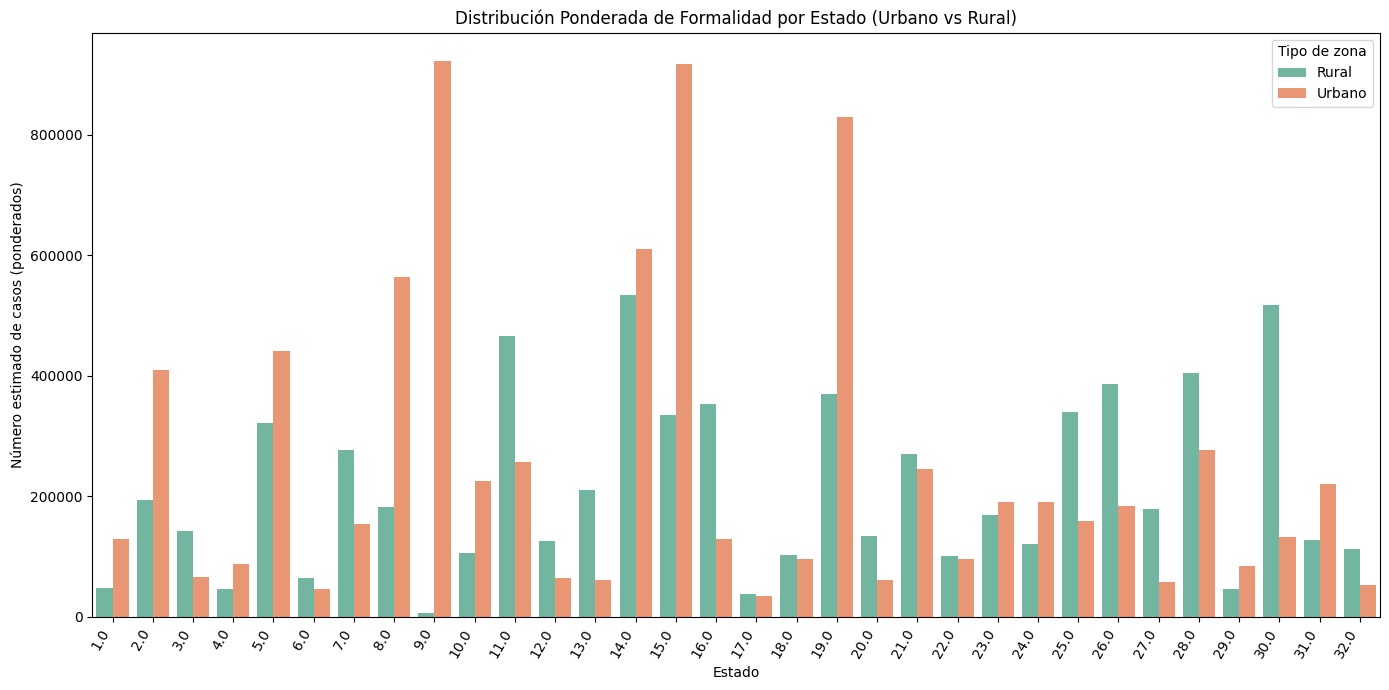

In [428]:
#eExacammente lo mismo de arriba pero para formales
df_formal['zona'] = df_formal['ur'].map({1: 'Urbano', 2: 'Rural'}).astype('category')

for_zona = df_formal.groupby(['ent', 'zona'], observed=True)['fac_tri'].sum().reset_index()

plt.figure(figsize=(14, 7))
sns.barplot(data=for_zona, x='ent', y='fac_tri', hue='zona', palette='Set2')
plt.title('Distribución Ponderada de Formalidad por Estado (Urbano vs Rural)')
plt.xlabel('Estado')
plt.ylabel('Número estimado de casos (ponderados)')
plt.xticks(rotation=60, ha='right')
plt.legend(title='Tipo de zona')
plt.tight_layout()
plt.savefig('dist_pond_form_estado.png', dpi = 300)
plt.show()

##### Para estos gráficos, no me fue posible colocar el nombre de los estados sin que se movieran los datos o se encimaran (por la longitud). A simple vista, podemos observar que los trabajos informales tienen una mayor presencia en el ámbito rural, a diferencia de los formales que parecen predominar en el ámbito urbano. Sin embargo, para mayor entendimiento, sería prudente un análisis enfatizando zonas urbanas marginales

# Comparación de ingresos entre formales e informales

In [435]:
ingresos_informales_estado = df_informal.groupby('ent')['ingocup'].mean().sort_values(ascending=False).reset_index()

# Renombrar columnas para mayor claridad
ingresos_informales_estado.columns = ['Entidad', 'Ingreso Promedio']

print(tabulate(ingresos_informales_estado, headers='keys', tablefmt='github'))

|    |   Entidad |   Ingreso Promedio |
|----|-----------|--------------------|
|  0 |         2 |            8839.53 |
|  1 |         8 |            7849.05 |
|  2 |         3 |            7751.52 |
|  3 |        19 |            7714.07 |
|  4 |        14 |            7601.89 |
|  5 |        25 |            7427.01 |
|  6 |        26 |            7407.34 |
|  7 |        23 |            7143.3  |
|  8 |         5 |            7119.81 |
|  9 |         6 |            7118.27 |
| 10 |        18 |            7094.4  |
| 11 |        22 |            7072.44 |
| 12 |         1 |            7019.19 |
| 13 |        28 |            6892.04 |
| 14 |        16 |            6714.88 |
| 15 |         9 |            6688.35 |
| 16 |        11 |            6453.3  |
| 17 |        10 |            6435.33 |
| 18 |        12 |            6408.68 |
| 19 |        15 |            6395.47 |
| 20 |        32 |            6275.9  |
| 21 |        27 |            6234.19 |
| 22 |        31 |            6200.83 |


In [434]:
# Calcular el ingreso promedio ponderado por estado
ingresos_ponderados_inf = df_informal.groupby('ent').apply(
    lambda x: (x['ingocup'] * x['fac_tri']).sum() / x['fac_tri'].sum()
).reset_index(name='Ingreso Promedio')

# Ordenar los resultados
ingresos_ponderados_inf.columns = ['Entidad', 'Ingreso Promedio']

ingresos_ponderados_inf = ingresos_ponderados_inf.sort_values(by='Ingreso Promedio', ascending=False)

print(tabulate(ingresos_ponderados_inf, headers='keys', tablefmt='github'))

|    |   Entidad |   Ingreso Promedio |
|----|-----------|--------------------|
|  1 |         2 |            8915.46 |
|  2 |         3 |            7816.86 |
|  7 |         8 |            7732.32 |
| 18 |        19 |            7715.11 |
| 13 |        14 |            7530.31 |
| 22 |        23 |            7272.42 |
| 25 |        26 |            7221.95 |
|  5 |         6 |            7189.27 |
| 24 |        25 |            7162.18 |
|  4 |         5 |            7147.95 |
| 17 |        18 |            7132.47 |
| 21 |        22 |            7059.46 |
|  0 |         1 |            6968.11 |
| 15 |        16 |            6763.03 |
|  8 |         9 |            6728.12 |
| 27 |        28 |            6525.54 |
| 14 |        15 |            6293.8  |
| 10 |        11 |            6245.54 |
|  9 |        10 |            6215.83 |
| 31 |        32 |            6167.98 |
| 30 |        31 |            6152.36 |
| 16 |        17 |            6111.71 |
| 11 |        12 |            6078.67 |


C:\Users\ASTRID\AppData\Local\Temp\ipykernel_19500\4262402822.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ingresos_ponderados_inf = df_informal.groupby('ent').apply(


In [433]:
ingresos_formales_estado = df_formal.groupby('ent')['ingocup'].mean().sort_values(ascending=False).reset_index()
ingresos_formales_estado.columns = ['Entidad', 'Ingreso Promedio']
print(tabulate(ingresos_formales_estado, headers='keys', tablefmt='github'))

|    |   Entidad |   Ingreso Promedio |
|----|-----------|--------------------|
|  0 |         2 |           13197.3  |
|  1 |         3 |           12875.6  |
|  2 |         9 |           12185.6  |
|  3 |        19 |           12017.1  |
|  4 |         8 |           11933.1  |
|  5 |         6 |           11770.6  |
|  6 |        23 |           11742.6  |
|  7 |        13 |           11670.8  |
|  8 |        25 |           11556.9  |
|  9 |        24 |           11513.3  |
| 10 |        26 |           11450.8  |
| 11 |         5 |           11416.7  |
| 12 |        18 |           11395.4  |
| 13 |         4 |           11393.8  |
| 14 |        20 |           11370.3  |
| 15 |        14 |           11313    |
| 16 |        28 |           11298.4  |
| 17 |        16 |           11186.2  |
| 18 |        27 |           11155.9  |
| 19 |        31 |           10883.2  |
| 20 |        32 |           10829.2  |
| 21 |        30 |           10828.7  |
| 22 |         1 |           10820.5  |


In [430]:
ingresos_ponderados_for = df_formal.groupby('ent').apply(
    lambda x: (x['ingocup'] * x['fac_tri']).sum() / x['fac_tri'].sum()
).reset_index(name='Ingreso Promedio')

# ordenar los resultados
ingresos_ponderados_for = ingresos_ponderados_for.sort_values(by='Ingreso Promedio', ascending=False)
ingresos_ponderados_for.columns = ['Entidad', 'Ingreso Promedio']

print(tabulate(ingresos_ponderados_for, headers='keys', tablefmt='github'))

|    |   Entidad |   Ingreso Promedio |
|----|-----------|--------------------|
|  1 |         2 |           13213.2  |
|  2 |         3 |           12825.2  |
|  8 |         9 |           12425.1  |
| 18 |        19 |           12085.4  |
|  5 |         6 |           11964.7  |
|  7 |         8 |           11763.5  |
| 22 |        23 |           11724.1  |
|  4 |         5 |           11440.1  |
| 23 |        24 |           11389.4  |
| 17 |        18 |           11377.3  |
| 25 |        26 |           11301.8  |
|  3 |         4 |           11257.4  |
| 27 |        28 |           11237.8  |
| 19 |        20 |           11206.9  |
| 13 |        14 |           11163.1  |
| 24 |        25 |           11071.4  |
| 15 |        16 |           11052.6  |
|  0 |         1 |           10983.4  |
| 12 |        13 |           10969.9  |
| 30 |        31 |           10757.9  |
| 29 |        30 |           10718.9  |
| 26 |        27 |           10699.5  |
| 21 |        22 |           10567.1  |


C:\Users\ASTRID\AppData\Local\Temp\ipykernel_19500\1172884849.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ingresos_ponderados_for = df_formal.groupby('ent').apply(


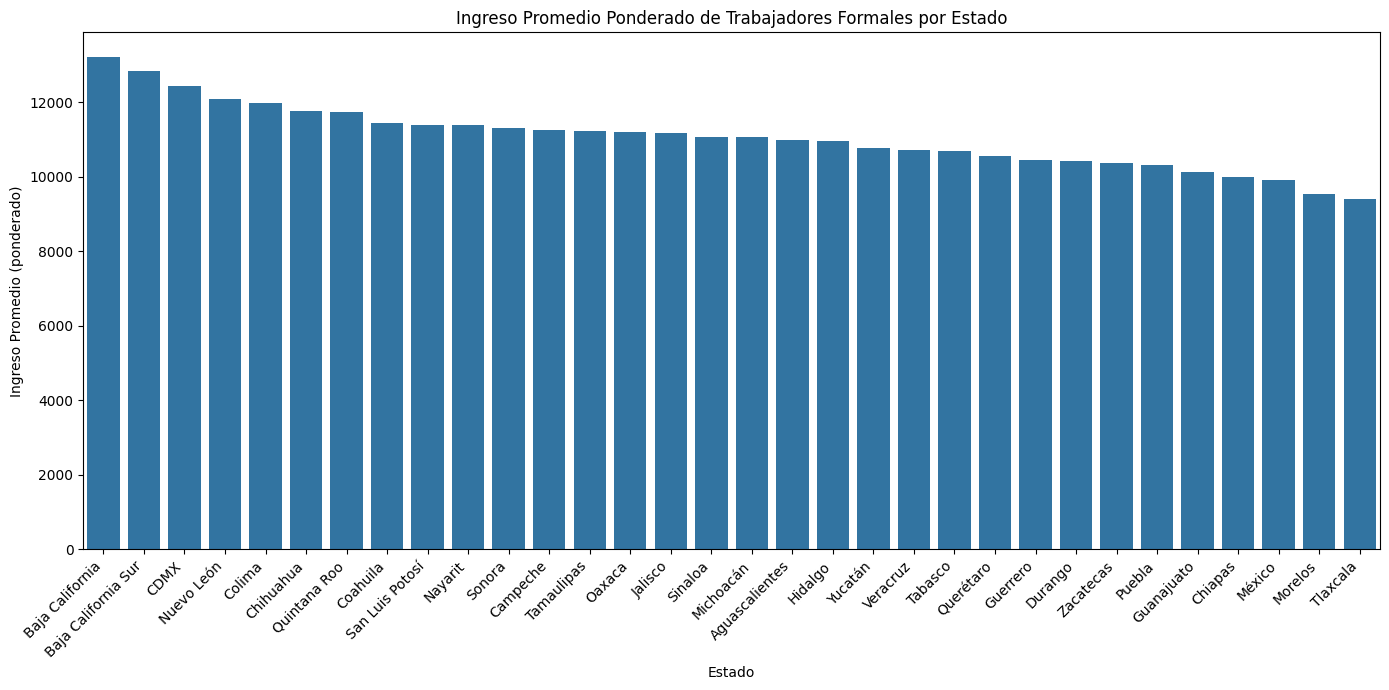

In [431]:
ingresos_ponderados_for['Entidad'] = ingresos_ponderados_for['Entidad'].map(entidades)

# ordenar por ingreso promedio para graficar
ingresos_ponderados_for = ingresos_ponderados_for.sort_values(by='Ingreso Promedio', ascending=False)

plt.figure(figsize=(14, 7))
sns.barplot(data=ingresos_ponderados_for, x='Entidad', y='Ingreso Promedio')

plt.title('Ingreso Promedio Ponderado de Trabajadores Formales por Estado')
plt.xlabel('Estado')
plt.ylabel('Ingreso Promedio (ponderado)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('ing_prom_inf_estado.png', dpi = 300)
plt.show()

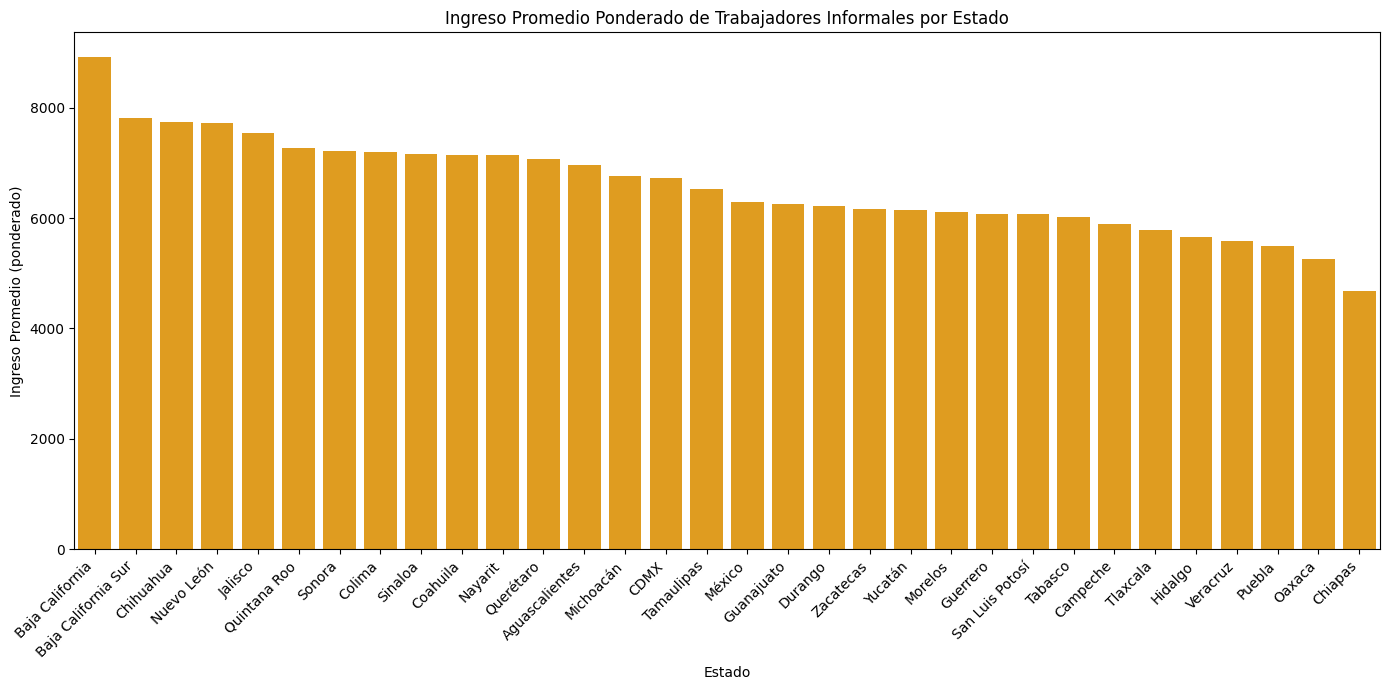

In [436]:
ingresos_ponderados_inf['Entidad'] = ingresos_ponderados_inf['Entidad'].map(entidades)
ingresos_ponderados_inf = ingresos_ponderados_inf.sort_values(by='Ingreso Promedio', ascending=False)


plt.figure(figsize=(14, 7))
sns.barplot(data=ingresos_ponderados_inf, x='Entidad', y='Ingreso Promedio', color='orange')
plt.title('Ingreso Promedio Ponderado de Trabajadores Informales por Estado')
plt.xlabel('Estado')
plt.ylabel('Ingreso Promedio (ponderado)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('ing_prom_inf_estado.png', dpi = 300)
plt.show()

##### Es interesante notar que entre los estados con menor ingreso promedio de los trabajadores informales, se encuentran los estados que concentran la mayor cantidad de estos trabajadores. Es decir, estados con altos niveles de informalidad y con los ingresos más bajos

# Prueba de correlación para ingreso por nivel educativo, sector formal o informal

In [437]:
df_formal['nivel_educ'] = df_formal['cs_p13_1'].apply(clasificar_educacion)  # Crea la columna usando la funcion pre establecida en ambos df principales
df_informal['nivel_educ'] = df_informal['cs_p13_1'].apply(clasificar_educacion)

# filtro según nivel educativo
df_edu_bas_inf = df_informal[(df_informal['nivel_educ'] == 'Básica')]
df_edu_sup_inf = df_informal[(df_informal['nivel_educ']) == 'Superior']
df_edu_bas_for = df_formal[(df_formal['nivel_educ']) == 'Básica']
df_edu_sup_for = df_formal[(df_formal['nivel_educ'] == 'Superior')]

from scipy.stats import shapiro

# Primero, confirmemos normalidad del ingreso con una prueba Shapiro-Wilk
grupos = {
    'Básica Informal': df_edu_bas_inf['ingocup'],
    'Superior Informal': df_edu_sup_inf['ingocup'],
    'Básica Formal': df_edu_bas_for['ingocup'],
    'Superior Formal': df_edu_sup_for['ingocup']
}
#En esta prueba de hipótesis, H0 es que las muestras tienen distribución normal, y H1 es que no la tienen
for nombre, datos in grupos.items():
    if len(datos) < 3:
        print(f"{nombre}: muestra muy pequeña para Shapiro-Wilk")
        continue
    
    stat, p = shapiro(datos)
    print(f"{nombre} - Estadístico W: {stat:.4f}, p-valor: {p:.4f}")
    if p > 0.05:
        print(f"  => Parece seguir distribución normal (no se rechaza H0)")
    else:
        print(f"  => No parece normal (se rechaza H0)")


Básica Informal - Estadístico W: 0.9718, p-valor: 0.0000
  => No parece normal (se rechaza H0)
Superior Informal - Estadístico W: 0.9718, p-valor: 0.0000
  => No parece normal (se rechaza H0)
Básica Formal - Estadístico W: 0.9425, p-valor: 0.0000
  => No parece normal (se rechaza H0)
Superior Formal - Estadístico W: 0.9609, p-valor: 0.0000
  => No parece normal (se rechaza H0)


c:\Users\ASTRID\Documents\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 34973.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\ASTRID\Documents\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 22831.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\ASTRID\Documents\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 18485.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\ASTRID\Documents\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 36323.
  res = hypotest_fun_out(*samples, **kwds)


# Prueba Kruskal-Wallis : prueba no paramétrica. Relación entre ingreso y nivel educativo para trabajadores formales e informales

### H0: Las distribuciones de los grupos son iguales (no hay diferencias en la mediana entre grupos).

### H1: Al menos una distribución es diferente (hay diferencias en la mediana entre grupos).

In [241]:
from scipy.stats import kruskal

stat, p = kruskal(df_edu_bas_inf['ingocup'],
                  df_edu_sup_inf['ingocup'],
                  df_edu_bas_for['ingocup'],
                  df_edu_sup_for['ingocup'])

print(f"Kruskal-Wallis H: {stat:.4f}, p-valor: {p:.4f}")

if p < 0.05:
    print("Rechazamos la hipótesis nula: al menos un grupo difiere significativamente")
else:
    print("No podemos rechazar la hipótesis nula: no hay diferencias significativas entre grupos")

Kruskal-Wallis H: 28838.9908, p-valor: 0.0000
Rechazamos la hipótesis nula: al menos un grupo difiere significativamente


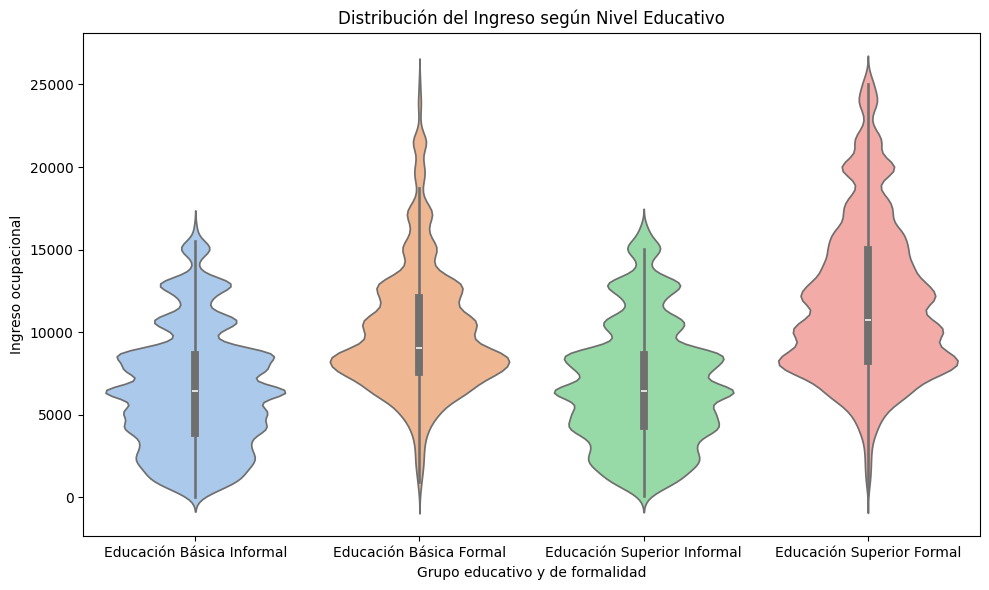

In [438]:
df_educacion = pd.concat([
    df_edu_bas_inf.assign(grupo='Educación Básica Informal'),
    df_edu_bas_for.assign(grupo='Educación Básica Formal'),
    df_edu_sup_inf.assign(grupo='Educación Superior Informal'),
    df_edu_sup_for.assign(grupo='Educación Superior Formal')
])

plt.figure(figsize=(10, 6))
sns.violinplot(x='grupo', y='ingocup', data=df_educacion, palette='pastel', hue='grupo', legend=False)
plt.xlabel('Grupo educativo y de formalidad')
plt.ylabel('Ingreso ocupacional')
plt.title('Distribución del Ingreso según Nivel Educativo')
plt.tight_layout()
plt.savefig('dist_ing_niv_edu.png', dpi = 300)
plt.show()

#### Rechazamos la hipótesis nula. Ahora, hay que saber por qué
## Prueba post-hoc: Dunn test para múltiples comparaciones

In [242]:
!pip install scikit-posthocs

  Obtaining dependency information for scikit-posthocs from https://files.pythonhosted.org/packages/d6/21/506f0ab734ad73f9215b09e04a05b393170c391349778f0c676a7b88cb7a/scikit_posthocs-0.11.4-py3-none-any.whl.metadata



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [317]:
import scikit_posthocs as sp
# Para esta prueba, hay que combinar los cuatro df en uno solo
df_combinado = pd.concat([df_edu_bas_inf, df_edu_sup_inf, df_edu_bas_for, df_edu_sup_for], 
                         keys=["Básica Informal", "Superior Informal", "Básica Formal", "Superior Formal"])

df_combinado = df_combinado.reset_index(level=0).rename(columns={'level_0': 'grupo'}) #arreglando la columna 

# prueba
posthoc = sp.posthoc_dunn(df_combinado, val_col='ingocup', group_col='grupo', p_adjust='bonferroni') #bonferroni para evitar/controlar error tipo I

print(posthoc)


                   Básica Formal  Básica Informal  Superior Formal  \
Básica Formal       1.000000e+00     0.000000e+00    2.237347e-279   
Básica Informal     0.000000e+00     1.000000e+00     0.000000e+00   
Superior Formal    2.237347e-279     0.000000e+00     1.000000e+00   
Superior Informal   0.000000e+00     1.193313e-16     0.000000e+00   

                   Superior Informal  
Básica Formal           0.000000e+00  
Básica Informal         1.193313e-16  
Superior Formal         0.000000e+00  
Superior Informal       1.000000e+00  


### Los resultados indican que hay diferencias estadísticamente significativas entre educación básica en ambos sectores, en Superior Informal y Básica Formal

# Prueba Kruskal-Wallis: prueba no paramétrica. Relación ingreso-duración de la jornada laboral para trabajadores formales e informales

### H0: Las distribuciones de los grupos son iguales (no hay diferencias en la mediana entre grupos).

### H1: Al menos una distribución es diferente (hay diferencias en la mediana entre grupos).

In [ ]:
#Primer paso: definir la duración de la jornada
df_jor_norm_formal = df_formal[df_formal['dur9c'].isin([6,5,4,3,2])] #menos o igual a 48 horas semanales
df_jor_alt_formal = df_formal[df_formal['dur9c'].isin([7,8])] # más de 48 horas semanales

df_jor_norm_informal = df_informal[df_informal['dur9c'].isin([6,5,4,3,2])]
df_jor_alt_informal = df_informal[df_informal['dur9c'].isin([7,8])]

In [248]:
stat, p = kruskal(df_jor_norm_formal['ingocup'],
                  df_jor_alt_formal['ingocup'],
                  df_jor_norm_informal['ingocup'],
                  df_jor_alt_informal['ingocup'])

print(f"Kruskal-Wallis H: {stat:.4f}, p-valor: {p:.4f}")

if p < 0.05:
    print("Rechazamos la hipótesis nula: al menos un grupo difiere significativamente")
else:
    print("No podemos rechazar la hipótesis nula: no hay diferencias significativas entre grupos")

Kruskal-Wallis H: 30899.0750, p-valor: 0.0000
Rechazamos la hipótesis nula: al menos un grupo difiere significativamente


In [298]:
#aplicar la Shapiro (aunque deducimos que no tienen normalidad por la prueba anterior), pero ahora en la duracion de la jornada
grupos_jornada = {
    'Jornada Normal Formal': df_jor_norm_formal['dur9c'],
    'Jornada Alta Formal': df_jor_alt_formal['dur9c'],
    'Jornada Normal Informal': df_jor_norm_informal['dur9c'],
    'Jornada Alta Informal': df_jor_alt_informal['dur9c']
}

# Iterar y aplicar la prueba Shapiro-Wilk a cada grupo
for nombre, datos in grupos_jornada.items():
    datos_limpios = datos.dropna()  # Quitar valores nulos si hay
    
    if len(datos_limpios) < 3:
        print(f"{nombre}: muestra muy pequeña para Shapiro-Wilk")
        continue
    
    stat, p = shapiro(datos_limpios)
    print(f"{nombre} - Estadístico W: {stat:.4f}, p-valor: {p:.4f}")
    
    if p > 0.05:
        print("  => Parece seguir distribución normal (no se rechaza H0)")
    else:
        print("  => No parece normal (se rechaza H0)")


Jornada Normal Formal - Estadístico W: 0.4928, p-valor: 0.0000
  => No parece normal (se rechaza H0)
Jornada Alta Formal - Estadístico W: 0.6365, p-valor: 0.0000
  => No parece normal (se rechaza H0)
Jornada Normal Informal - Estadístico W: 0.8191, p-valor: 0.0000
  => No parece normal (se rechaza H0)
Jornada Alta Informal - Estadístico W: 0.6366, p-valor: 0.0000
  => No parece normal (se rechaza H0)


c:\Users\ASTRID\Documents\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 39427.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\ASTRID\Documents\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14344.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\ASTRID\Documents\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 41498.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\ASTRID\Documents\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14153.
  res = hypotest_fun_out(*samples, **kwds)


In [299]:
#prueba kruskal-wallis para la duracion de la jornada
stat, p = kruskal(df_jor_norm_formal['dur9c'],
                  df_jor_alt_formal['dur9c'],
                  df_jor_norm_informal['dur9c'],
                  df_jor_alt_informal['dur9c'])

print(f"Kruskal-Wallis H: {stat:.4f}, p-valor: {p:.4f}")

if p < 0.05:
    print("Rechazamos la hipótesis nula: al menos un grupo difiere significativamente")
else:
    print("No podemos rechazar la hipótesis nula: no hay diferencias significativas entre grupos")

Kruskal-Wallis H: 77370.4901, p-valor: 0.0000
Rechazamos la hipótesis nula: al menos un grupo difiere significativamente


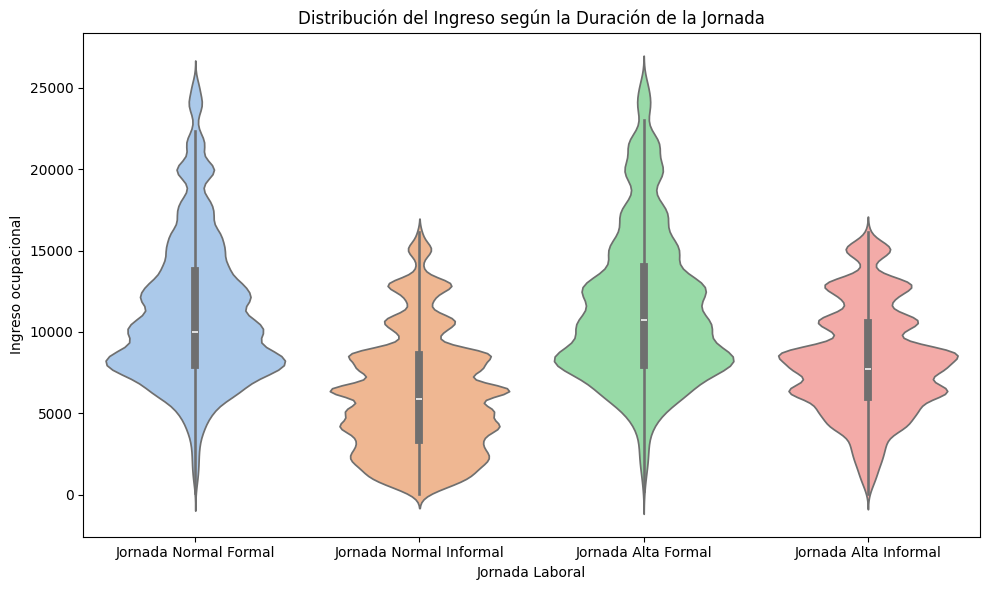

In [364]:
df_jornada = pd.concat([
    df_jor_norm_formal.assign(grupo='Jornada Normal Formal'),
    df_jor_norm_informal.assign(grupo='Jornada Normal Informal'),
    df_jor_alt_formal.assign(grupo='Jornada Alta Formal'),
    df_jor_alt_informal.assign(grupo='Jornada Alta Informal')
])

plt.figure(figsize=(10, 6))
sns.violinplot(x='grupo', y='ingocup', data=df_jornada, palette='pastel', hue='grupo', legend=False)


plt.xlabel('Jornada Laboral')
plt.ylabel('Ingreso ocupacional')
plt.title('Distribución del Ingreso según la Duración de la Jornada')
plt.tight_layout()
plt.savefig('dist_ing_dur_jorn.jpg', dpi = 300)
plt.show()

#### Rechazamos la hipótesis nula. Ahora, hay que saber por qué
## Prueba post-hoc: Dunn test para múltiples comparaciones

In [440]:
import scikit_posthocs as sp
# Volvemos a unir los df en uno solo
df_jornada_combinado = pd.concat([df_jor_norm_formal, df_jor_alt_formal, df_jor_norm_informal, df_jor_alt_informal], 
                         keys=["Jornada Normal Formal", "Jornada Alta Formal", "Jornada Normal Informal", "Jornada Alta Informal"])

df_jornada_combinado = df_jornada_combinado.reset_index(level=0).rename(columns={'level_0': 'grupo'})
posthoc = sp.posthoc_dunn(df_jornada_combinado, val_col='ingocup', group_col='grupo', p_adjust='bonferroni')

print(posthoc)

                         Jornada Alta Formal  Jornada Alta Informal  \
Jornada Alta Formal             1.000000e+00                    0.0   
Jornada Alta Informal           0.000000e+00                    1.0   
Jornada Normal Formal           9.586641e-08                    0.0   
Jornada Normal Informal         0.000000e+00                    0.0   

                         Jornada Normal Formal  Jornada Normal Informal  
Jornada Alta Formal               9.586641e-08                      0.0  
Jornada Alta Informal             0.000000e+00                      0.0  
Jornada Normal Formal             1.000000e+00                      0.0  
Jornada Normal Informal           0.000000e+00                      1.0  


In [303]:
# prueba para la duracion
posthoc = sp.posthoc_dunn(df_jornada_combinado, val_col='dur9c', group_col='grupo', p_adjust='bonferroni') #bonferroni para evitar/controlar error tipo I

print(posthoc)

                         Jornada Alta Formal  Jornada Alta Informal  \
Jornada Alta Formal                      1.0                    1.0   
Jornada Alta Informal                    1.0                    1.0   
Jornada Normal Formal                    0.0                    0.0   
Jornada Normal Informal                  0.0                    0.0   

                         Jornada Normal Formal  Jornada Normal Informal  
Jornada Alta Formal                        0.0                      0.0  
Jornada Alta Informal                      0.0                      0.0  
Jornada Normal Formal                      1.0                      0.0  
Jornada Normal Informal                    0.0                      1.0  


##### Hay diferencias estadisticamente significativas entre las jornadas altas de formales e informales: los formales ganan más por mayor tiempo trabajado que los informales

# Prueba Chi-cuadrada para relación entre sector económico y tipo de empleo

In [445]:
from scipy.stats import chi2_contingency

df_formal['form'] = 'Formal'
df_informal['form'] = 'Informal'
df_chi = pd.concat([df_formal, df_informal])
#contingencia = pd.crosstab(df_chi['rama_est1'], df_chi['form']) -> esta es la prueba pero no permite ponderarlo, lo descubrí en el gráfico

contingencia = pd.pivot_table(df_chi, 
                                        values='fac_tri', 
                                        index='rama_est1', 
                                        columns='form', 
                                        aggfunc='sum', 
                                        fill_value=0) 

# Prueba Chi-cuadrada sobre la tabla ponderada
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(contingencia)

print("Estadístico Chi-cuadrada:", chi2)
print("p-valor:", p)
print("Grados de libertad:", dof)
print("\nTabla obtenida (ponderada):")
print(contingencia)
print("\nTabla esperada (ponderada):")
print(pd.DataFrame(expected, index=contingencia.index, columns=contingencia.columns))


Estadístico Chi-cuadrada: 1283848.3942181328
p-valor: 0.0
Grados de libertad: 3

Tabla obtenida (ponderada):
form          Formal    Informal
rama_est1                       
1.0         595904.0   3100279.0
2.0        4545720.0   4851683.0
3.0        9679635.0  11415927.0
4.0          18648.0     66592.0

Tabla esperada (ponderada):
form             Formal      Informal
rama_est1                            
1.0        1.600350e+06  2.095833e+06
2.0        4.068828e+06  5.328575e+06
3.0        9.133823e+06  1.196174e+07
4.0        3.690667e+04  4.833333e+04


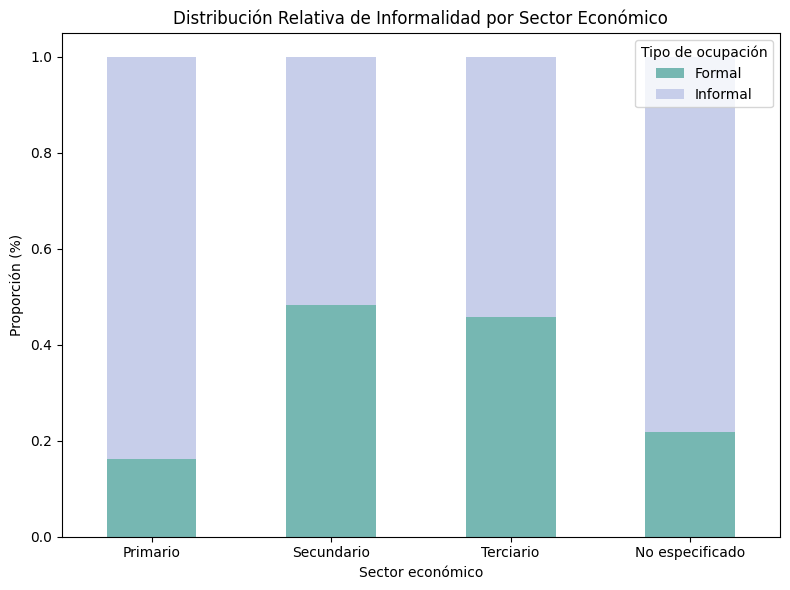

In [446]:
sectores = {
    1.0: 'Primario',
    2.0: 'Secundario',
    3.0: 'Terciario',
    4.0: 'No especificado'
}

contingencia_norm = contingencia.div(contingencia.sum(axis=1), axis=0) #esto permite ver los porcentajes dentro de cada sector, no las cantidades reales
contingencia_norm.rename(index=sectores, inplace=True)

contingencia_norm.plot(kind='bar', stacked=True, figsize=(8,6), color =[ '#76B7B2', '#C7CEEA'])
plt.title('Distribución Relativa de Informalidad por Sector Económico')
plt.ylabel('Proporción (%)')
plt.xlabel('Sector económico')
plt.legend(title='Tipo de ocupación', labels=['Formal', 'Informal'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('dist_porc_inf_estado.png', dpi = 300)
plt.show()

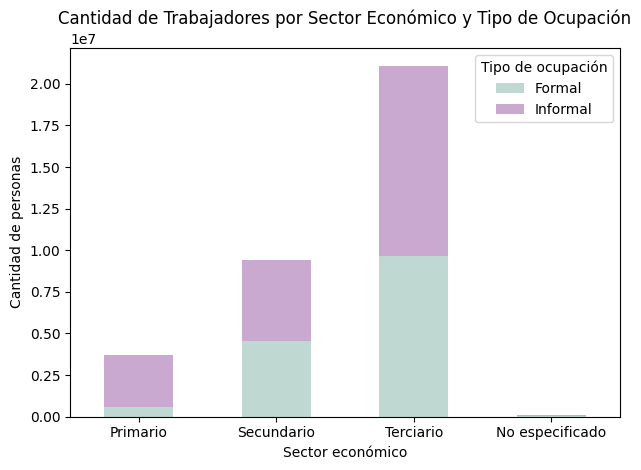

In [447]:
# Esta sí permite ver las cantidades reales de trabajadores
contingencia.plot(kind='bar', stacked=True, color=['#BFD8D2', "#CAA9D0"])
contingencia.rename(index=sectores, inplace=True)
plt.title('Cantidad de Trabajadores por Sector Económico y Tipo de Ocupación')
plt.ylabel('Cantidad de personas')
plt.xlabel('Sector económico')
plt.legend(title='Tipo de ocupación', labels=['Formal', 'Informal'])
plt.xticks(ticks=range(4), labels=['Primario', 'Secundario', 'Terciario', 'No especificado'], rotation=0)
plt.tight_layout()
plt.savefig('relacion_sector_ocupacion.png', dpi = 300)
plt.show()


### Observamos que en el sector primario hay un mayor porcentaje de informalidad, mientras que el secundario y terciarion mantienen una relación caso 50/50. Si embargo, en cantidades reales y no porcentuales, el sector terciario (servicios) es el que, sin duda, alberga la mayor cantidad de trabajadores informales

## Discusión

##### Los hallazgos del análisis realizado permiten profundizar en las características estructurales que conforman la informalidad laboral en México.

##### En primer lugar, la edad de los trabajadores informales revela una tendencia preocupante. Aunque diversos estudios afirman que la informalidad se concentra entre los 18 y 40 años, los datos muestran que la inserción comienza incluso antes de los 18. La informalidad, por tanto, no es solo un fenómeno juvenil o transitorio, sino que afecta de forma estructural a grupos vulnerables en ambos extremos de la edad productiva: a quienes se incorporan de forma prematura y a quienes no pueden retirarse adecuadamente.

##### Respecto al sexo, tanto la literatura como este análisis coinciden: los hombres representan la mayoría dentro del empleo informal. Esto puede relacionarse con los sectores y tipos de ocupación en los que suele concentrarse la informalidad, donde los hombres tienen mayor participación.

##### En cuanto al nivel educativo, se confirma que una menor escolaridad es un factor asociado a la informalidad. El 61.4% de los trabajadores informales cuenta únicamente con educación básica, y dentro de este grupo, el 57.57% concluyó la secundaria. Esto sugiere una alta vulnerabilidad en la adolescencia, reflejada en niveles significativos de deserción escolar. 


##### Desde una perspectiva geográfica, los estados con mayor número de trabajadores informales —Veracruz, Chiapas y Puebla— también figuran entre aquellos con salarios más bajos. Es importante resaltar que los estados con mayor informalidad también presentan altos niveles de ruralidad, lo que evidencia que la informalidad se concentra en regiones marginadas.

##### Finalmente, el análisis sectorial muestra que aunque el sector primario presenta el mayor porcentaje de informalidad, es el sector terciario el que concentra la mayor cantidad absoluta de trabajadores informales, siendo casi ocho veces más grande que el sector primario.


## Conclusión

##### De acuerdo a los resultados y la discusión derivada de este análisis, se concluye que el trabajador informal promedio en México es un hombre joven, alrededor de los 39 años, con un nivel educativo bajo, que trabaja subordinadamente en microempresas o unidades económicas pequeñas dedicadas principalmente al sector de los servicios, ubicadas en estados con altos índices de ruralidad; y que percibe un salario por debajo del trabajador formal sin importar cuántas horas labore.

##### Esto demuestra que el problema de la informalidad no recae en los deseos individuales de “salir adelante” ni se resuelve con “echarle más ganas”. Es un problema sistemático y multifacético que afecta especialmente a mujeres —limitadas en el acceso al mundo laboral—, a jóvenes —por la alta deserción educativa—, a regiones rurales o regiones alejadas de grandes urbes, y a sectores económicos poco tecnificados o marginados.

## Bibliografía

##### OIT. (2013). FORLAC (Oficina Regional para América Latina y el Caribe, Ed.). ilo.org. https://www.ilo.org/es/media/453181/download

##### Rodríguez, E. C., de la Torre Ruiz, H. A., & Dávila, S. O. R. (Eds.). (2016). Características y determinantes de la informalidad laboral en México. Estudios regionales en economía, población y desarrollo. (Núm. 35). Universidad Autónoma de Ciudad Juárez.